In [128]:
from os import getcwd
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
work_dir = getcwd()
data_dir = join(work_dir, "data")
image_dir = join(work_dir, "image")

In [130]:
ip_country = pd.read_csv(join(data_dir, "IpAddress_to_Country.csv"))
fraud_data = pd.read_csv(join(data_dir, "Fraud_Data.csv"))
#fraud_data = pd.read_csv(join(data_dir, "fraud_data_country.csv")) # fichier déjà pré-traité (datetime, ip_address, country)

In [131]:
print(f"{ip_country.shape = }, {fraud_data.shape = }")

ip_country.shape = (138846, 3), fraud_data.shape = (151112, 11)


### Exploration ip_country

In [132]:
ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [133]:
ip_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [134]:
ip_country.nunique()

lower_bound_ip_address    138846
upper_bound_ip_address    138846
country                      235
dtype: int64

In [135]:
# conversion de lower_bound_ip_address en int
ip_country["lower_bound_ip_address"] = ip_country["lower_bound_ip_address"].astype("int64")

In [136]:
ip_country[["lower_bound_ip_address"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 1 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   lower_bound_ip_address  138846 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


In [159]:
ip_country.query("country == 'China'").tail(10)

,lower_bound_ip_address,upper_bound_ip_address,country
138815,3755737088,3755868159,China
138822,3755978752,3755982847,China
138823,3755982848,3755986943,China
138829,3757047808,3757572095,China
138830,3757572096,3757834239,China
138832,3757867008,3757899775,China
138834,3757965312,3758030847,China
138835,3758030848,3758063615,China
138840,3758091264,3758092287,China
138843,3758095360,3758095871,China


### Exploration fraud_data

In [137]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [138]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


### conversion de ip_address en int

In [139]:
fraud_data["ip_address"] = fraud_data["ip_address"].astype("int64")

### conversion des features datetime

In [140]:
fraud_data["signup_time"] = pd.to_datetime(fraud_data["signup_time"], infer_datetime_format=True)
fraud_data["purchase_time"] = pd.to_datetime(fraud_data["purchase_time"], infer_datetime_format=True)

In [141]:
fraud_data[["ip_address", "signup_time", "purchase_time"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ip_address     151112 non-null  int64         
 1   signup_time    151112 non-null  datetime64[ns]
 2   purchase_time  151112 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 3.5 MB


In [142]:
ip = fraud_data["ip_address"][0]
ip_country[(ip >= ip_country.lower_bound_ip_address) & (ip <= ip_country.upper_bound_ip_address)]["country"].iloc[0]

'Japan'

### Ajout de la colonne country à partir de l'adresse IP

In [143]:
def get_country(ip, ip_country_dataset):
    """
    Return the name of the country based on the ip address
    """
    try:
        country = ip_country_dataset[
            (ip >= ip_country_dataset.lower_bound_ip_address) & (ip <= ip_country_dataset.upper_bound_ip_address)
        ]["country"].iloc[0]
    except:
        return "unknown"
    else:
        return country

In [144]:
fraud_data["country"] = fraud_data["ip_address"]
fraud_data["country"] = fraud_data["country"].apply(get_country, args=(ip_country,))

### Sauvegarde du fichier fraud_data_country

In [145]:
fraud_data.to_csv(join(data_dir, "fraud_data_country.csv"))

In [146]:
fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country'],
      dtype='object')

### user_id et device_id quasiment tous unique

In [171]:
fraud_data[["user_id", "device_id"]].nunique() / fraud_data.shape[0]

user_id      1.000000
device_id    0.912939
dtype: float64

In [147]:
time = [
    'signup_time',
    'purchase_time'
]

categorical = [
    'source', 
    'browser', 
    'sex',
    'country'
]

numerical = [
    'purchase_value',
    'age'
]

target = ["class"]

In [161]:
unknown_country = fraud_data[fraud_data["country"] == "unknown"]
unknown_country.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,unknown
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3987484328,0,unknown
11,73884,2015-05-29 16:22:02,2015-06-16 05:45:58,58,ZTZZJUCRDOCJZ,Direct,Chrome,M,32,4038284553,0,unknown
12,79203,2015-06-16 21:19:35,2015-06-21 03:29:59,18,IBPNKSMCKUZWD,SEO,Safari,M,33,4161540926,0,unknown
14,82931,2015-02-16 02:50:30,2015-04-16 00:56:47,15,XKIFNYUZMBWFU,SEO,IE,M,24,4203487753,0,unknown


In [233]:
fraud_data[time + categorical].describe(include="all")

,signup_time,purchase_time,source,browser,sex,country
count,151112,151112,151112,151112,151112,151112
unique,151112,150679,3,5,2,182
top,2015-06-30 03:58:38,2015-07-17 23:22:55,SEO,Chrome,M,United States
freq,1,3,60615,61432,88293,58049
first,2015-01-01 00:00:42,2015-01-01 00:00:44,NaN,NaN,NaN,NaN
last,2015-08-18 04:40:29,2015-12-16 02:56:05,NaN,NaN,NaN,NaN


In [234]:
fraud_data[numerical + target].describe()

,purchase_value,age,class
count,151112.000000,151112.000000,151112.000000
mean,36.935372,33.140704,0.093646
std,18.322762,8.617733,0.291336
min,9.000000,18.000000,0.000000
25%,22.000000,27.000000,0.000000
50%,35.000000,33.000000,0.000000
75%,49.000000,39.000000,0.000000
max,154.000000,76.000000,1.000000


### Distribution de la cible

In [210]:
target_ratio = [f"{r:.2%}" for r in fraud_data["class"].value_counts() / fraud_data.shape[0]]
target_ratio

['90.64%', '9.36%']

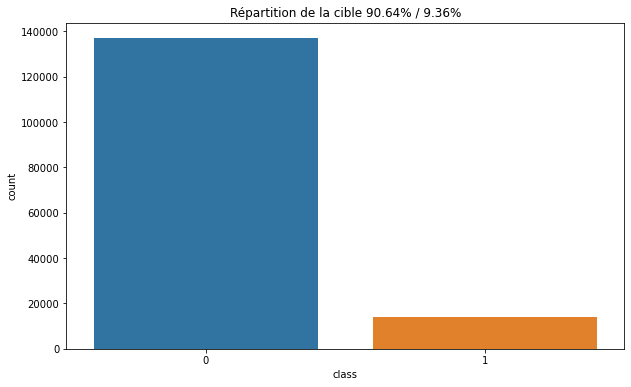

In [217]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(data=fraud_data, x="class", ax=ax)
ax.set_title(f"Répartition de la cible {target_ratio[0]} / {target_ratio[1]}")

plt.show()
#fig.savefig(join(image_dir, 'dist_cible.png'), transparent=False, dpi=80, bbox_inches="tight")

### Distribution de l'âge

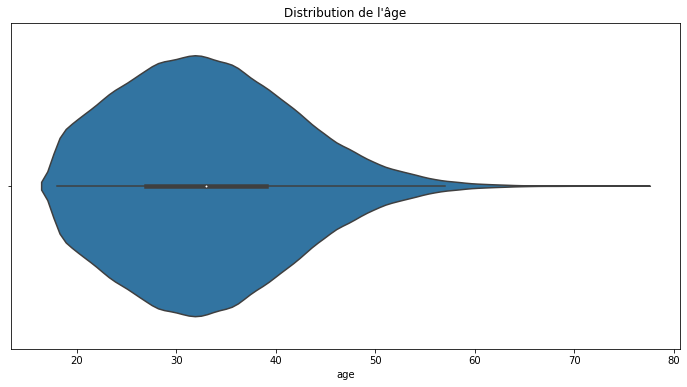

In [222]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.violinplot(data=fraud_data, x="age", ax=ax)
ax.set_title(f"Distribution de l'âge")

plt.show()
#fig.savefig(join(image_dir, 'dist_age.png'), transparent=False, dpi=80, bbox_inches="tight")

In [244]:
# même répartition des fraudes

borne_sup_age = fraud_data["age"].mean() + 3 * fraud_data["age"].std()
fraud_data[fraud_data["age"] > borne_sup_age]["class"].value_counts()

0    504
1     49
Name: class, dtype: int64

### Distribution du panier

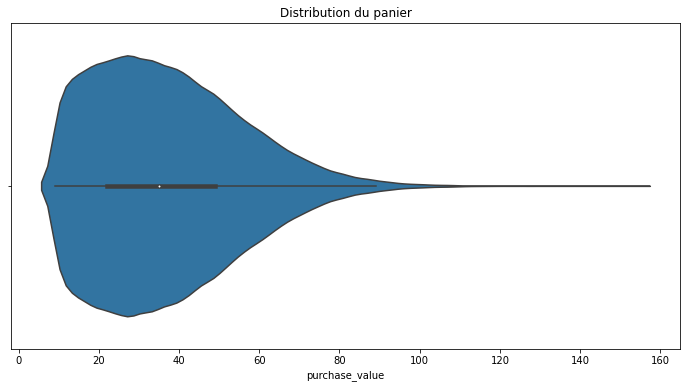

In [311]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.violinplot(data=fraud_data, x="purchase_value", ax=ax)
ax.set_title(f"Distribution du panier")

plt.show()
#fig.savefig(join(image_dir, 'dist_purchase.png'), transparent=False, dpi=80, bbox_inches="tight")

In [245]:
# même répartition des fraudes

borne_sup_panier = fraud_data["purchase_value"].mean() + 3 * fraud_data["purchase_value"].std()
fraud_data[fraud_data["purchase_value"] > borne_sup_panier]["class"].value_counts()

0    788
1     77
Name: class, dtype: int64

### Distribution du genre

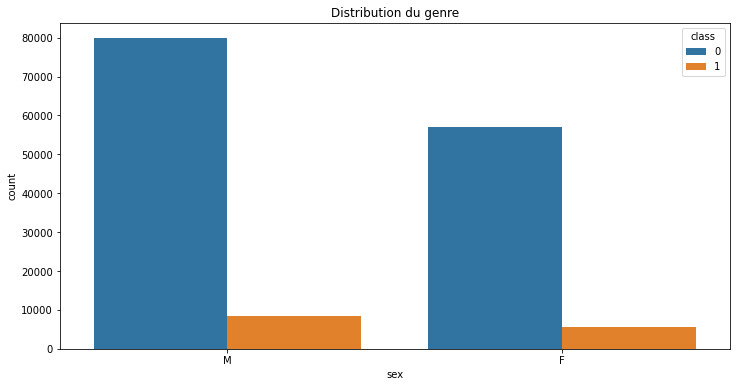

In [309]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=fraud_data, x="sex", hue="class", ax=ax)
ax.set_title(f"Distribution du genre")

plt.show()
#fig.savefig(join(image_dir, 'dist_genre.png'), transparent=False, dpi=80, bbox_inches="tight")

### Distribution de la source

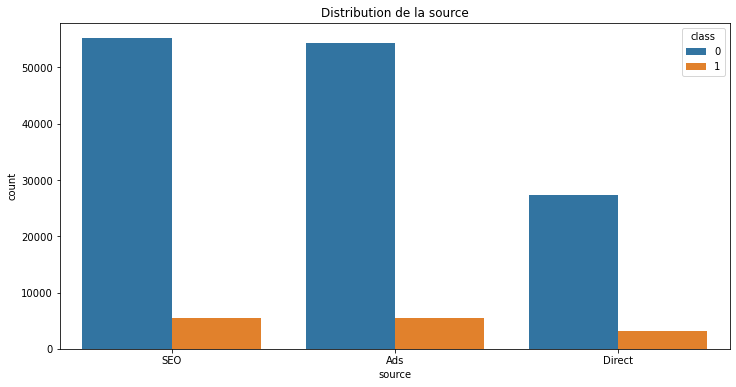

In [308]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=fraud_data, x="source", hue="class", ax=ax)
ax.set_title(f"Distribution de la source")

plt.show()
#fig.savefig(join(image_dir, 'dist_source.png'), transparent=False, dpi=80, bbox_inches="tight")

### Distribution des navigteurs

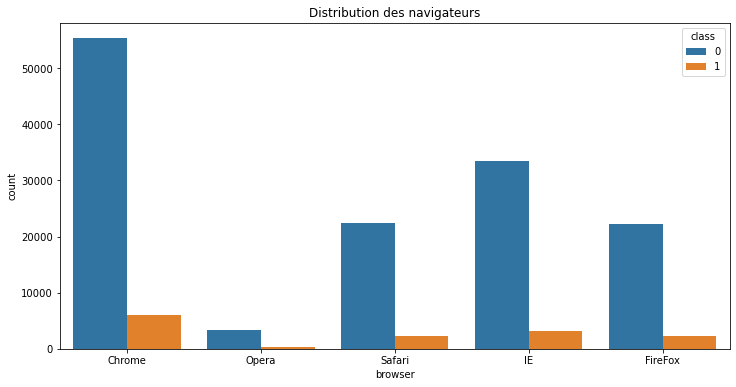

In [312]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=fraud_data, x="browser", hue="class", ax=ax)
ax.set_title(f"Distribution des navigateurs")

plt.show()
#fig.savefig(join(image_dir, 'dist_browser.png'), transparent=False, dpi=80, bbox_inches="tight")

### Répartition de la fraude par pays

In [351]:
t = 0.90
country_count = fraud_data[fraud_data["class"] == 1].groupby("country")["class"].count().sort_values(ascending=False).reset_index()
country_count = country_count[country_count["class"] > country_count["class"].quantile(t)]

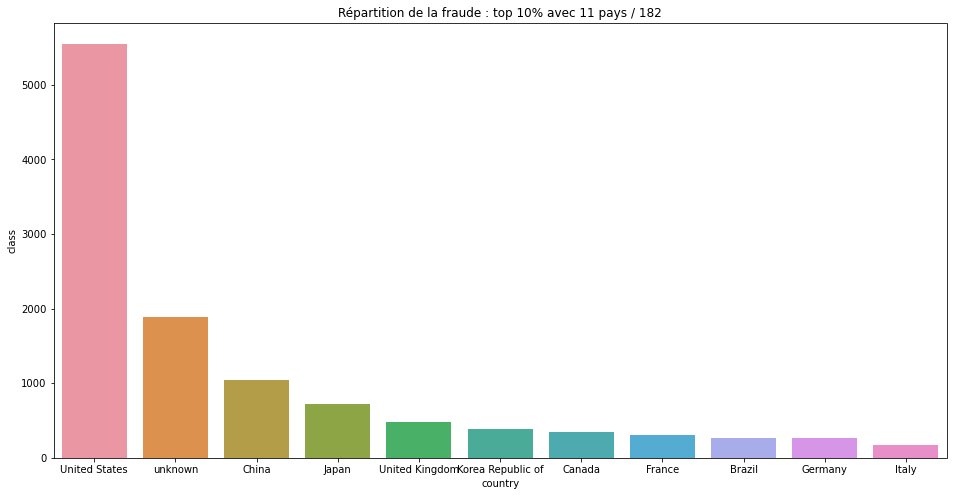

In [353]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.barplot(data=country_count, x="country", y="class", ax=ax)
ax.set_title(f"Répartition de la fraude : top {1-t:.0%} avec {len(country_count)} pays / {fraud_data['country'].nunique()}")

plt.show()
#fig.savefig(join(image_dir, 'dist_pays.png'), transparent=False, dpi=80, bbox_inches="tight")

### Relations avec la cible

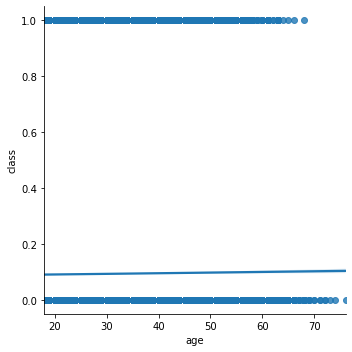

In [307]:
g = sns.lmplot(data=fraud_data, y="class", x="age", logistic=True)